In [22]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# grhpviz
from sklearn.tree import export_graphviz

import graphviz


# 기계 학습 모델 필요 모듈
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 모델 성능 평가
from sklearn.metrics import confusion_matrix

# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 구성

### 데이터 전처리

In [2]:
df_raw = pd.read_csv("Data/HMEQ.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3734 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3667 non-null   object 
 6   YOJ      3543 non-null   float64
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3718 non-null   float64
 9   CLAGE    3711 non-null   float64
 10  NINQ     3692 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.8+ KB


In [3]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
## 범주형 변수
df_raw["JOB"].fillna("Other", inplace=True)

## 연속형 변수
# 결측치 있는 모든 열을 평균으로 대체
df_raw.fillna(df_raw.mean(), inplace =True)

In [5]:
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### 더미변수 생성

In [6]:
# REASON과 JOB데이터의 더미변수 생성

df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis=1, inplace = False)

### train_data 분할
- 학습데이터와 테스트 데이터의 분할은 머신러닝에서 사용한다. 로지스틱 회귀분석에서는 하지 않는다.
- 변수를 자를 때는 앞의 변수를 2개로 자르고, 다음 변수를 2개 자른다.

In [8]:
# train_test_split (7:3으로 트레인과 테스트 데이터가 나눠진다.)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (2623, 18)
train data Y size: (2623,)
test data X size: (1125, 18)
test data Y size: (1125,)


In [13]:
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

#test데이터 정확
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.963
Accuracy on test set: 0.941


In [14]:
gb_uncustomized

GradientBoostingClassifier(random_state=1234)

- 역시 데이터에 부분 과적합되어있는 상태라고 볼 수 있다.

## 2. 모델 하이퍼 파라미터 튜닝
- 하이퍼 파라미터 튜닝을 할 때 어떤 파라미터를 먼저 하느냐에 따라서 값이 달라질 수가 있다.

- learning_reate
- n_estimator
- max_depth
- n_samples_leaf
- n_samples_split

### learning_rate: 0.1 선정

In [23]:
train_score = []; test_score = []

para_lr = [lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GBC(random_state=1234,learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["LearningRate"] = para_lr
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

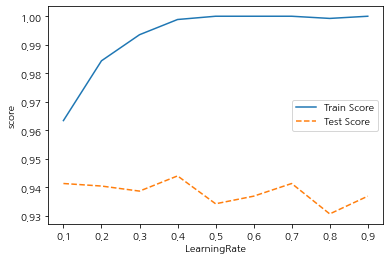

In [24]:
plt.plot(para_lr, train_score, linestyle="-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle="--", label = "Test Score")
plt.xlabel("LearningRate")
plt.ylabel("score")
plt.legend()

※ learning_rate 0.1 선정

In [25]:
# 모델 설명력 확인
df_score_leaf.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937


### n_estimators: 100으로 선정

In [59]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 16)] # 10 ~ 150

for v_n_estimators in para_n_tree:
    gb = GBC(random_state=1234, learning_rate = 0.1, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainScore"] = train_score
df_accuracy_n["TestScore"] = test_score

In [60]:
df_accuracy_n.round(3)

# Train과 Test Score의 Gap이 크다면 모델이 불안정한 것으로 볼 수 있다.

,n_estimators,TrainScore,TestScore
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.939
7,80,0.960,0.939
8,90,0.961,0.940
9,100,0.963,0.941


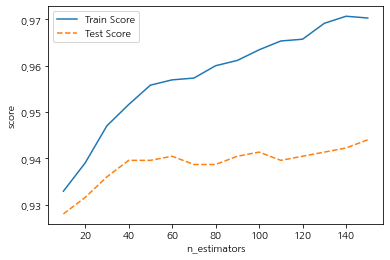

In [61]:
plt.plot(para_n_tree, train_score, linestyle="-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label = "Test Score")
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.legend()

### MaxDepth = 3으로 선정

In [29]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1, 10)]

for v_max_depth in para_depth:
    gb = GBC(random_state=1234, n_estimators=40,
                                  learning_rate = 0.1, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["MaxDepth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

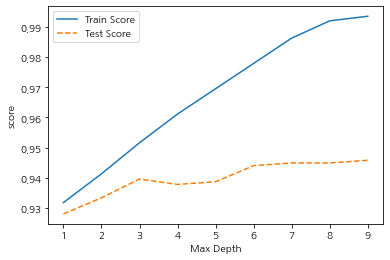

In [30]:
plt.plot(para_depth, train_score, linestyle="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle="--", label = "Test Score")
plt.xlabel("Max Depth")
plt.ylabel("score")
plt.legend()

In [31]:
df_score_depth.round(3)

,MaxDepth,TrainScore,TestScore
0,1,0.932,0.928
1,2,0.941,0.933
2,3,0.952,0.940
3,4,0.961,0.938
4,5,0.970,0.939
5,6,0.978,0.944
6,7,0.986,0.945
7,8,0.992,0.945
8,9,0.994,0.946


- 깊이가 3일 더 좋아보인다.

### min_samples_split: 70으로 선정

In [32]:
train_score = []; test_score = []

para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    gb = GBC(random_state=1234, n_estimators=40,
                                  learning_rate = 0.1, max_depth=3, 
             min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

In [33]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,10,0.950,0.939
1,20,0.950,0.939
2,30,0.946,0.935
3,40,0.947,0.938
4,50,0.945,0.936
5,60,0.947,0.936
6,70,0.945,0.939
7,80,0.945,0.939
8,90,0.945,0.939
9,100,0.940,0.937


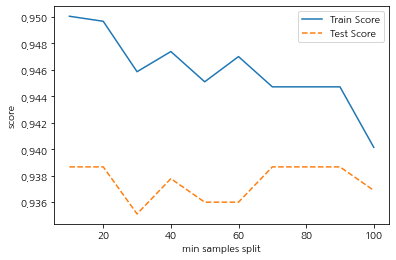

In [34]:
plt.plot(para_split, train_score, linestyle="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle="--", label = "Test Score")
plt.xlabel("min samples split")
plt.ylabel("score")
plt.legend()

- min_sampels_split은 50으로 선정하겠다.

### min_samples_leaf: 40으로 선정

In [49]:
train_score = []; test_score = []

para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GBC(random_state=1234, n_estimators = 40, max_depth=3, learning_rate = 0.1, 
             min_samples_split=70, min_samples_leaf= v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [50]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,10,0.942,0.940
1,20,0.943,0.937
2,30,0.937,0.933
3,40,0.933,0.931
4,50,0.935,0.930
5,60,0.932,0.932
6,70,0.933,0.930
7,80,0.933,0.933
8,90,0.927,0.929
9,100,0.927,0.930


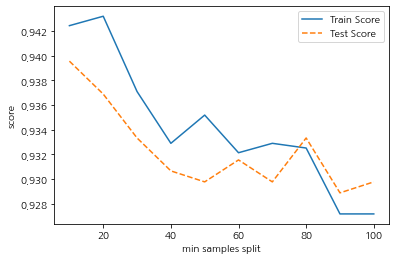

In [51]:
plt.plot(para_leaf, train_score, linestyle="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label = "Test Score")
plt.xlabel("min samples split")
plt.ylabel("score")
plt.legend()

- min_sampels_leaf는 60으로 선정하겠다.

### 하이퍼 파라미터 튜닝 결과
- learning_rate:0.1
- n_estimator: 100
- 최대 깊이: 4
- min_sampled_split: 70
- min_samples_leaf:60

## 3. 결론도출
- 최종모델 선택

In [58]:
gb_final = GBC(random_state=1234, learning_rate = 0.1, n_estimators = 100, max_depth=3,  
             min_samples_split=70, min_samples_leaf=60)
gb_final.fit(df_train_x, df_train_y)

y_pred = gb_final.predict(df_test_x)

# Train 데이터 설명력
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
#test데이터 설명력
print("Accuracy on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))
# Confusion Matrix
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))


Accuracy on training set: 0.946
Accuracy on test set: 0.937
Comfusion Matrix: 
[[1020    1]
 [  70   34]]


- train, test 데이터의 정분류율이 비슷한 수준으로 안정적인 모델임을 알 수 있다.

### 결론도출: 설명변수의 중요도

In [16]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.465
5,DELINQ,0.190
4,DEROG,0.068
7,NINQ,0.066
6,CLAGE,0.059
8,CLNO,0.050
2,VALUE,0.034
0,LOAN,0.029
3,YOJ,0.016
1,MORTDUE,0.011


Text(0, 0.5, '변수')

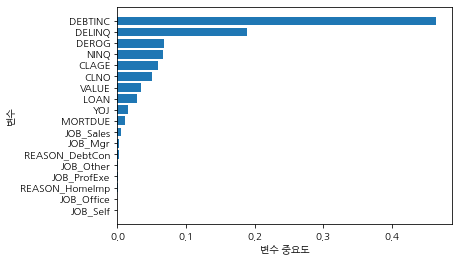

In [17]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- 중요 설명변수: 트리 생성 시 부채비율(DEBTINC), 연체된 신용 한도(DELINQ)의 순으로 영향도가 큰 순으로 해석할 수 있다.
- 단, 계산된 변수 주요도 값이 낮거나 0이더라도 선택되는 훈련 데이터에 따라 중요도가 변경될 수 있다.


- 중요 변수는 일부 하이퍼파라미터를 변경한다고 쉽게 바뀌지 않는다.